In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/for_stardist_bent_histmatched/convolutions/*.tif"))
Y = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/for_stardist_bent_histmatched/masks/*.tif"))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [4]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y.astype(int)) for y in tqdm(Y)]

100%|██████████| 6257/6257 [00:02<00:00, 2256.14it/s]


In [5]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.5 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 6257
- training:       3129
- validation:     3128


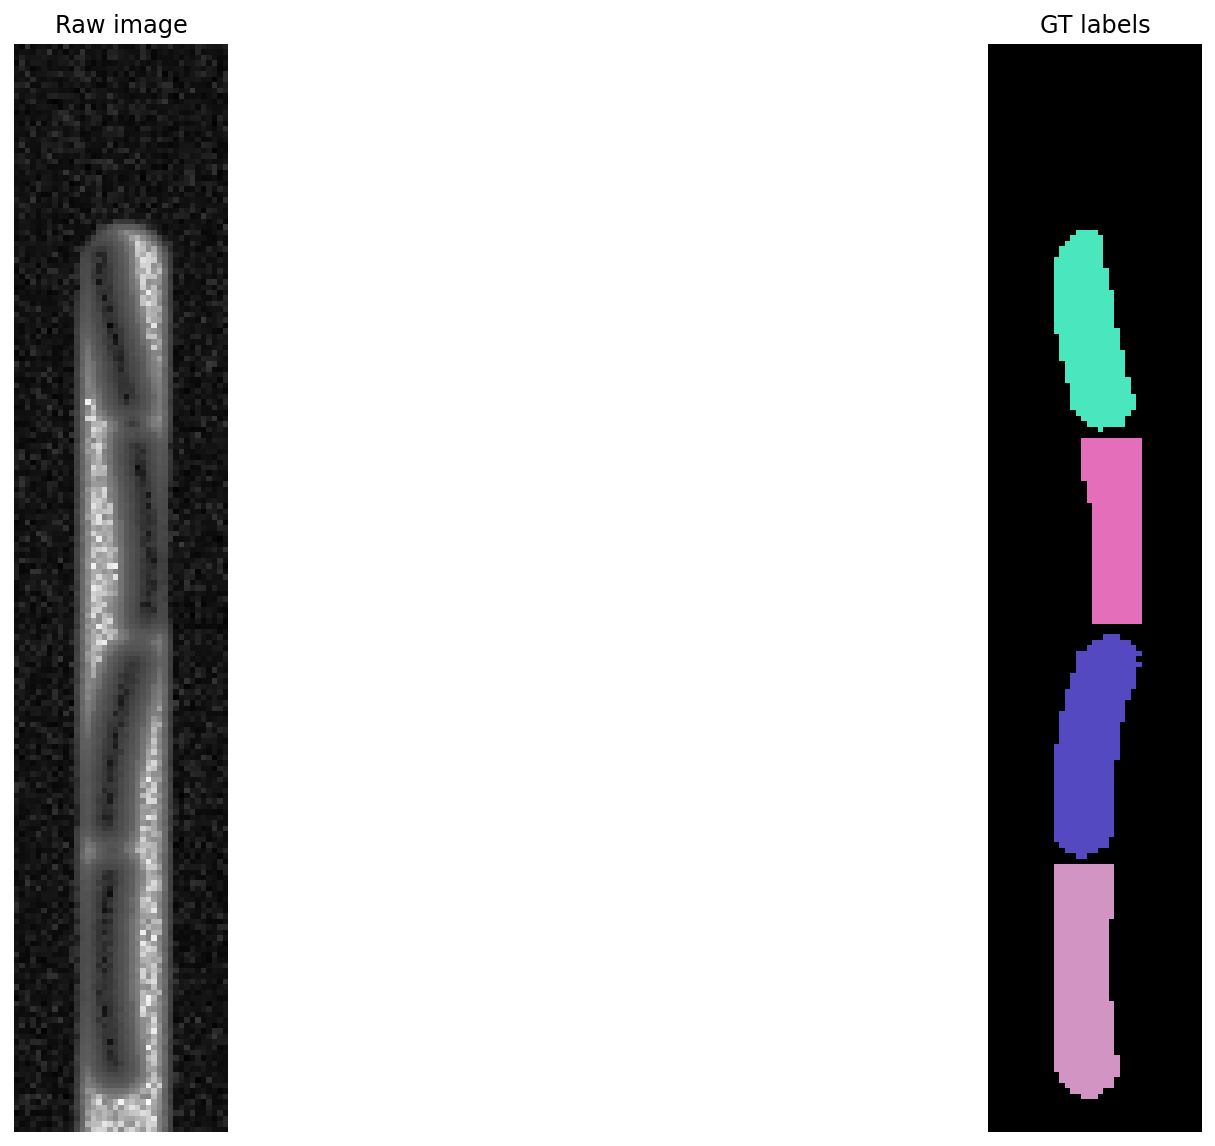

In [6]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [7]:
np.random.seed(42)
data = StarDistData2D(X,Y,batch_size=1,n_rays=120,patch_size=X[i].shape,shape_completion=False,length=1)

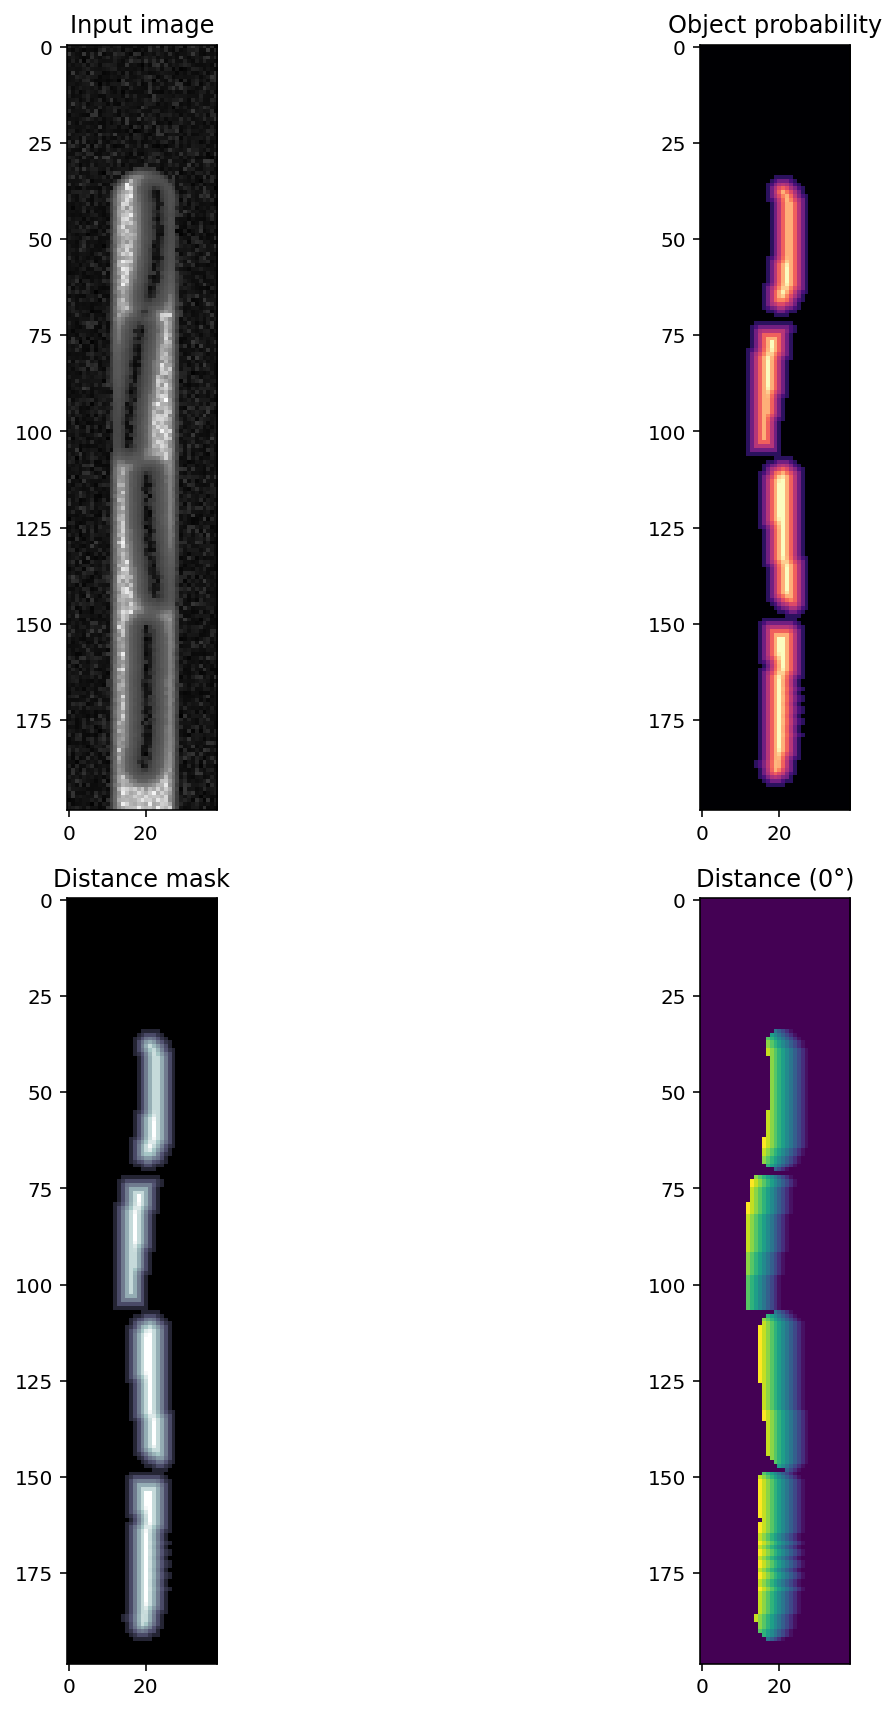

In [8]:

(img,), (prob,dist) = data[0]
dist, dist_mask = dist[...,:-1], dist[...,-1:]

fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img,prob,dist_mask,dist], ['gray','magma','bone','viridis'],
                    ['Input image','Object probability','Distance mask','Distance (0°)']):
    a.imshow(d[0,...,0],cmap=cm)
    a.set_title(s)
plt.tight_layout()
None;

In [9]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [12]:
conf = Config2D(
    n_channel_in=n_channel, 
    train_batch_size=4, 
    train_shape_completion=False, 
    train_patch_size=(192,32), 
    use_gpu=True,
    train_background_reg = 0.000001,
    train_learning_rate=0.0002,
    unet_batch_norm = True,
    unet_dropout=0.3,
    train_epochs=1600,
    unet_n_depth=5)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(1, 1), backbone='unet', n_classes=None, unet_n_depth=5, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=True, unet_dropout=0.3, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(192, 32), train_background_reg=1e-06, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=1600, train_steps_per_epoch=100, train_learning_rate=0.0002, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, us

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (1, 1),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 5,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': True,
 'unet_dropout': 0.3,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (192, 32),
 'train_background_reg': 1e-06,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 1600,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0002,
 '

In [13]:
model = StarDist2D(conf, name='stardist_no_shape_completion', basedir='models_mixed_size_1600_epoch_good_50')


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [14]:
%%capture train_log
model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


UnknownError: 2 root error(s) found.
  (0) Unknown:  MemoryError: clEnqueueNDRangeKernel failed: MEM_OBJECT_ALLOCATION_FAILURE
Traceback (most recent call last):

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/csbdeep/internals/train.py", line 114, in __iter__
    yield self[i]

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/stardist/models/model2d.py", line 74, in __getitem__
    dist      = np.stack([star_dist(lbl,self.n_rays,mode=self.sd_mode, grid=self.grid) for lbl in Y])

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/stardist/models/model2d.py", line 74, in <listcomp>
    dist      = np.stack([star_dist(lbl,self.n_rays,mode=self.sd_mode, grid=self.grid) for lbl in Y])

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/stardist/geometry/geom2d.py", line 83, in star_dist
    return _ocl_star_dist(a, n_rays, grid=grid)

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/stardist/geometry/geom2d.py", line 25, in _ocl_star_dist
    program.run_kernel('star_dist', res_shape[::-1], None, dst.data, src, np.int32(grid[0]),np.int32(grid[1]))

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/gputools/core/oclprogram.py", line 46, in run_kernel
    self._kernel_dict[name](self._dev.queue,global_size, local_size,*args,**kwargs)

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/pyopencl/__init__.py", line 888, in kernel_call
    return self._enqueue(self, queue, global_size, local_size, *args, **kwargs)

  File "<generated code>", line 8, in enqueue_knl_star_dist

pyopencl._cl.MemoryError: clEnqueueNDRangeKernel failed: MEM_OBJECT_ALLOCATION_FAILURE


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  MemoryError: clEnqueueNDRangeKernel failed: MEM_OBJECT_ALLOCATION_FAILURE
Traceback (most recent call last):

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/csbdeep/internals/train.py", line 114, in __iter__
    yield self[i]

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/stardist/models/model2d.py", line 74, in __getitem__
    dist      = np.stack([star_dist(lbl,self.n_rays,mode=self.sd_mode, grid=self.grid) for lbl in Y])

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/stardist/models/model2d.py", line 74, in <listcomp>
    dist      = np.stack([star_dist(lbl,self.n_rays,mode=self.sd_mode, grid=self.grid) for lbl in Y])

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/stardist/geometry/geom2d.py", line 83, in star_dist
    return _ocl_star_dist(a, n_rays, grid=grid)

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/stardist/geometry/geom2d.py", line 25, in _ocl_star_dist
    program.run_kernel('star_dist', res_shape[::-1], None, dst.data, src, np.int32(grid[0]),np.int32(grid[1]))

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/gputools/core/oclprogram.py", line 46, in run_kernel
    self._kernel_dict[name](self._dev.queue,global_size, local_size,*args,**kwargs)

  File "/home/georgeos/anaconda3/envs/tf2-gpu/lib/python3.9/site-packages/pyopencl/__init__.py", line 888, in kernel_call
    return self._enqueue(self, queue, global_size, local_size, *args, **kwargs)

  File "<generated code>", line 8, in enqueue_knl_star_dist

pyopencl._cl.MemoryError: clEnqueueNDRangeKernel failed: MEM_OBJECT_ALLOCATION_FAILURE


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7097]

Function call stack:
train_function -> train_function
